# Enfriamiento Simulado

Se ha de implementar el algoritmo de Enfriamiento Simulado (ES) con las siguientes 
componentes:  
* Esquema de enfriamiento: Se implementará el esquema de Cauchy, Tk = T0/(1 + k)
* Condición de enfriamiento L(T): Se enfriará la temperatura, y finalizará a la iteración actual, cuando se haya generado un número máximo de vecinos  (independientemente de si han sido o no aceptados).
* Condición de parada: El algoritmo finalizará cuando se alcance un número máximo de iteraciones (enfriamientos).  

Se calculará la temperatura inicial en función de la siguiente fórmula:  
T0 = (μ / (-log(Φ)) ) * C(Si)  
donde T0 es la temperatura inicial, C(Si) es el costo de la solución inicial y Φ[0,1] es la probabilidad de aceptar una solución un µ por 1 peor que la inicial. En las ejecuciones se considerar Φ=µ= 0,3.  
El número de soluciones generadas en cada temperatura será L(T) = 20 y el número de enfriamientos (iteraciones) será 80 ·n.  
Se debe repetir también 10 veces con distintas semillas, partiendo de una solución inicial aleatoria.

---
## Librerías
- matplotlib: necesaria para la representación de la solución.
- pandas: necesaria para la representación de resultados.
- random: necesaria para el control de números aleatorios.
- datetime: necesaria para la obtención de una semilla inicial que genere las demás semillas.
- multiprocessing: necesaria para la ejecución concurrente de las soluciones.
- itertools: necesaria para combinar las semillas con los dataset en la ejecución concurrente.
- ipynb: necesaria para cargar la función busqueda_aleatorio de otro fichero. Esto permite la ejecución concurrente en Jupyter.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from random import seed
from random import randint
from datetime import datetime
from multiprocessing import Pool, TimeoutError
import itertools
from ipynb.fs.full.algoritmo import *

---
## Funciones auxiliares
- cargar_fichero(nombre_fichero): devuelve un array con las ciudades almacenadas en el fichero. [ [ ciudad, posición x , posición y ] [...] ... ]
- calcular_distancia_euclidea(node_1,node_2): devuelve en la distancia entre las dos ciudades.
- dibujar_flecha(A, B): dibuja una flecha entre el punto A y B apuntando a B. 
- representacion(camino, nombre, distancia): representa las ciudades y el camino calculado.
- representacion_datos(result,nombre): representa la solución obtenida de la ejecución concurrente de un dataset.
- agregar_resultados(dataframe,nombre,result): guarda los resultados de la ejecución en el dataframe según la plantilla del pdf.

In [2]:
def cargar_fichero(nombre_fichero):
    
    fichero = open( "../Dataset/" + nombre_fichero + ".tsp", 'r')
    
    for i in range(3):
        fichero.readline()
        
    numero_de_ciudades = fichero.readline().strip().split()[1]
    
    for i in range(2):
        fichero.readline()
        
    ciudades = []
    for i in range(0, int(numero_de_ciudades)):
        ciudad,x,y = fichero.readline().strip().split()[:]
        ciudades.append([int(ciudad),float(x),float(y)])  
        
    fichero.close()
    
    return ciudades

In [3]:
def calcular_distancia_euclidea(ciudad_1,ciudad_2):
    
    x1,y1 = ciudad_1[1 :]
    x2,y2 = ciudad_2[1 :]
    
    xd = x1 - x2
    yd = y1 - y2
    
    return round(math.sqrt( xd*xd + yd*yd ))

In [4]:
def dibujar_flecha(A, B):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              head_width=1.3, length_includes_head=True)

In [5]:
def representacion(camino, nombre, distancia):
    
    plt.figure(figsize=(10,10))
    
    for i in range(len(camino)):
        if(i == 0):
            plt.plot(camino[i][1], camino[i][2] , "o", color="green")
        else:
            plt.plot(camino[i][1], camino[i][2] , "*", color="red")
        
        if(i<len(camino)-1):
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[i+1][1], camino[i+1][2]])
        else:
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[0][1], camino[0][2]])
    
    plt.title(nombre + " : " + str(distancia))

In [6]:
def representacion_datos(result,nombre):
    semilla_coste = pd.DataFrame(columns=["Semilla","Coste","Nº de evaluaciones"])
    for i in range(10):
        semilla_coste.loc[len(semilla_coste)] = [semillas[i],result[i][1], result[i][2]]
    display(semilla_coste)

    print("Media coste: ", semilla_coste[['Coste']].mean()[0])
    print("Desviación típica coste: ", semilla_coste[['Coste']].std()[0])
    print("Media nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].mean()[0])
    print("Desviación típica nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].std()[0])


    print()
    print("Representación de la mejor solución: ")
    indice = semilla_coste[['Coste']].idxmin()[0]


    representacion(result[indice][0], nombre, result[indice][1])

In [7]:
def agregar_resultados(dataframe,nombre,result):

    for i in range(10):
        dataframe.loc["Ejecución "+str(i+1),(nombre,"Coste")] = result[i][1]

    dataframe.loc["Media",(nombre,"Coste")] = resultados.loc[:"Ejecución 10",(nombre,"Coste")].mean()
    dataframe.loc["Des. Tip. (s)",(nombre,"Coste")] = resultados.loc[:"Ejecución 10",(nombre,"Coste")].std()

    for i in range(10):
        dataframe.loc["Ejecución "+str(i+1),(nombre,"#Ev")] = result[i][2]

    dataframe.loc["Media",(nombre,"#Ev")] = resultados.loc[:"Ejecución 10",(nombre,"#Ev")].mean()
    dataframe.loc["Des. Tip. (s)",(nombre,"#Ev")] = resultados.loc[:"Ejecución 10",(nombre,"#Ev")].std()

---
## Función de evaluación
Esta función genera el coste total de la solución pasara por parámetro. Para ello recorre todas las ciudades de la solución sumando el coste entre ellas. 

In [8]:
def funcion_de_evaluacion(solucion):
    coste = 0
    for indice in range(len(solucion)-1):
        coste += calcular_distancia_euclidea(solucion[indice],solucion[indice+1])
    coste += calcular_distancia_euclidea(solucion[-1],solucion[0])
    return coste

---
## Lectura de ficheros y ejecución del algoritmo
Para poder ejecutar correctamente el algoritmo de forma concurrente en Jupyter, este debe ser cargado de forma externa. Para ello se ha usado la librería ipynb.

In [9]:
st70 = cargar_fichero("st70")
ch130 = cargar_fichero("ch130")
a280 = cargar_fichero("a280")
p654 = cargar_fichero("p654")
vm1084 = cargar_fichero("vm1084")
vm1748 = cargar_fichero("vm1748")

### Generación de semillas

In [10]:
semillas = []
dt = datetime.now()
for i in range(10):
    semillas.append(randint(0,dt.microsecond))
print("Semillas generadas:")
print(semillas)

Semillas generadas:
[309443, 209690, 199874, 490251, 294678, 272589, 1777, 411847, 48383, 275070]


## Dataframe para ver los resultados

In [11]:
mux = pd.MultiIndex.from_product([["St70","Ch130","A280","Pa654","Vm1084","Vm1748"], ['Coste','#Ev']])
resultados = pd.DataFrame(
    columns=mux,
    index = ['Ejecución 1', 'Ejecución 2', 'Ejecución 3',"Ejecución 4","Ejecución 5","Ejecución 6","Ejecución 7","Ejecución 8","Ejecución 9","Ejecución 10","Media","Des. Tip. (s)"]
)

#### st70

,Semilla,Coste,Nº de evaluaciones
0,309443.0,971.0,112001.0
1,209690.0,931.0,112001.0
2,199874.0,1129.0,112001.0
3,490251.0,1012.0,112001.0
4,294678.0,1094.0,112001.0
5,272589.0,1005.0,112001.0
6,1777.0,1013.0,112001.0
7,411847.0,978.0,112001.0
8,48383.0,1097.0,112001.0
9,275070.0,973.0,112001.0


Media coste:  1020.3
Desviación típica coste:  64.90856817263975
Media nº de evaluaciones:  112001.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


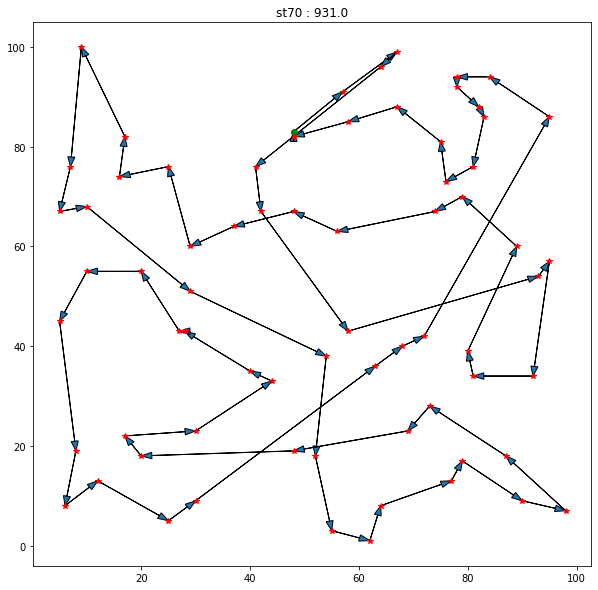

In [12]:
import time
dataset = st70
with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
representacion_datos(result,"st70")

agregar_resultados(resultados,"St70",result)

#### ch130


,Semilla,Coste,Nº de evaluaciones
0,309443.0,10006.0,208001.0
1,209690.0,11416.0,208001.0
2,199874.0,10553.0,208001.0
3,490251.0,10173.0,208001.0
4,294678.0,10396.0,208001.0
5,272589.0,11612.0,208001.0
6,1777.0,11576.0,208001.0
7,411847.0,10932.0,208001.0
8,48383.0,9577.0,208001.0
9,275070.0,10832.0,208001.0


Media coste:  10707.3
Desviación típica coste:  692.5805288115519
Media nº de evaluaciones:  208001.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


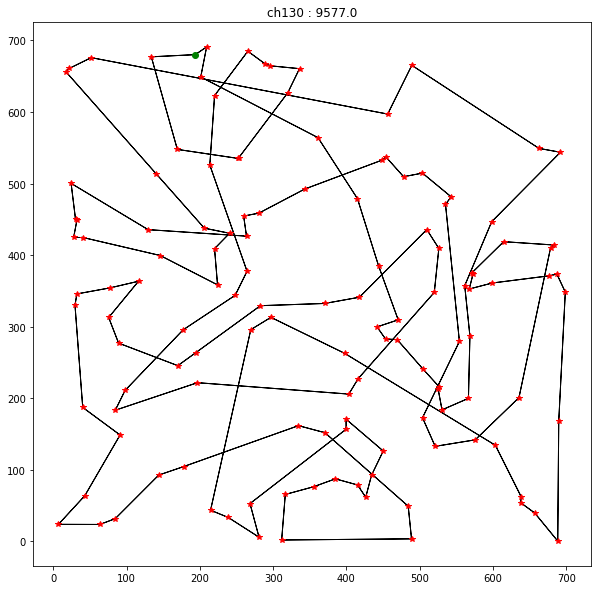

In [13]:
dataset = ch130

with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
    
representacion_datos(result,"ch130")

agregar_resultados(resultados,"Ch130",result)

#### a280

,Semilla,Coste,Nº de evaluaciones
0,309443.0,6752.0,448001.0
1,209690.0,6306.0,448001.0
2,199874.0,6386.0,448001.0
3,490251.0,6056.0,448001.0
4,294678.0,6451.0,448001.0
5,272589.0,6179.0,448001.0
6,1777.0,6304.0,448001.0
7,411847.0,6757.0,448001.0
8,48383.0,5849.0,448001.0
9,275070.0,6017.0,448001.0


Media coste:  6305.7
Desviación típica coste:  298.2810196218772
Media nº de evaluaciones:  448001.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


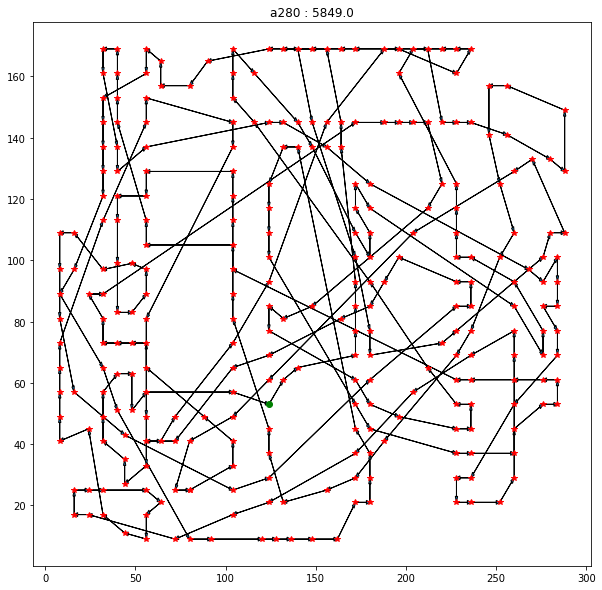

In [14]:
dataset = a280
with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )

representacion_datos(result,"a280")

agregar_resultados(resultados,"A280",result)

#### p654

,Semilla,Coste,Nº de evaluaciones
0,309443.0,360825.0,1046401.0
1,209690.0,343347.0,1046401.0
2,199874.0,323467.0,1046401.0
3,490251.0,347536.0,1046401.0
4,294678.0,330375.0,1046401.0
5,272589.0,328241.0,1046401.0
6,1777.0,282705.0,1046401.0
7,411847.0,313166.0,1046401.0
8,48383.0,303061.0,1046401.0
9,275070.0,293960.0,1046401.0


Media coste:  322668.3
Desviación típica coste:  24695.93483888931
Media nº de evaluaciones:  1046401.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


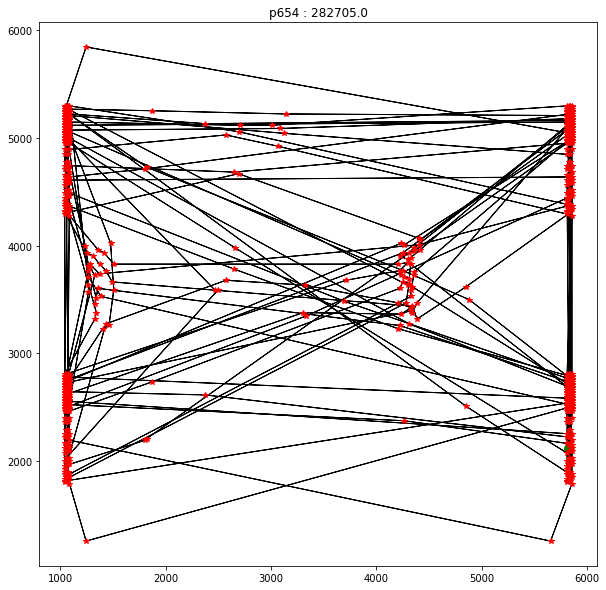

In [15]:
dataset = p654

with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
    
representacion_datos(result,"p654")

agregar_resultados(resultados,"Pa654",result)

#### vm1084

,Semilla,Coste,Nº de evaluaciones
0,309443.0,1315865.0,1734401.0
1,209690.0,1277981.0,1734401.0
2,199874.0,1264055.0,1734401.0
3,490251.0,1258736.0,1734401.0
4,294678.0,1295593.0,1734401.0
5,272589.0,1274642.0,1734401.0
6,1777.0,1301120.0,1734401.0
7,411847.0,1330433.0,1734401.0
8,48383.0,1177841.0,1734401.0
9,275070.0,1277980.0,1734401.0


Media coste:  1277424.6
Desviación típica coste:  41676.50795565504
Media nº de evaluaciones:  1734401.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


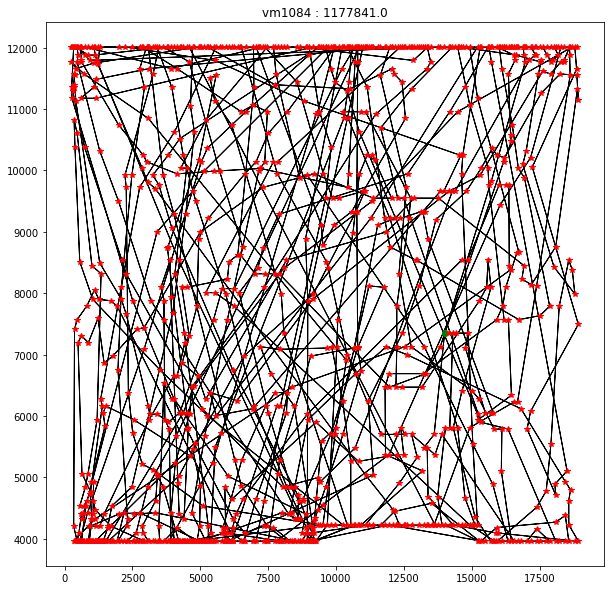

In [16]:
dataset = vm1084

with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
    
representacion_datos(result,"vm1084")

agregar_resultados(resultados,"Vm1084",result)

#### vm1748

,Semilla,Coste,Nº de evaluaciones
0,309443.0,2384911.0,2796801.0
1,209690.0,2417620.0,2796801.0
2,199874.0,2370424.0,2796801.0
3,490251.0,2206825.0,2796801.0
4,294678.0,2174382.0,2796801.0
5,272589.0,2366712.0,2796801.0
6,1777.0,2272068.0,2796801.0
7,411847.0,2311700.0,2796801.0
8,48383.0,2218595.0,2796801.0
9,275070.0,2255174.0,2796801.0


Media coste:  2297841.1
Desviación típica coste:  84605.26515195928
Media nº de evaluaciones:  2796801.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


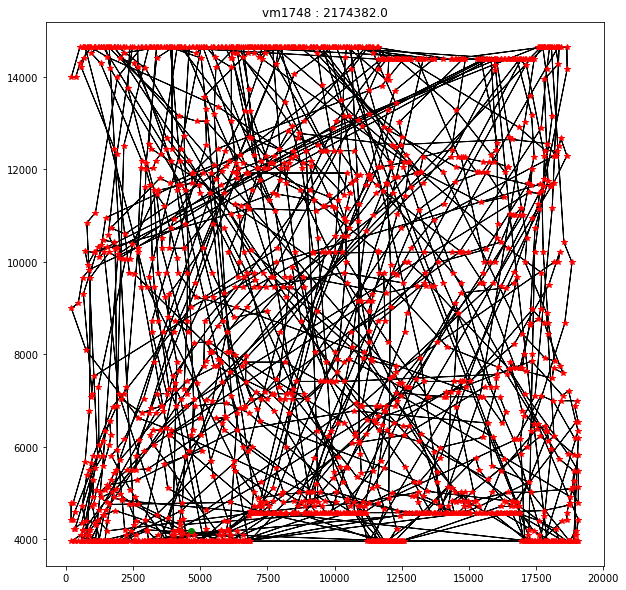

In [17]:
dataset = vm1748
with Pool(processes=5) as pool:
    result = pool.starmap(enfriamiento_simulado,  itertools.product(semillas,[dataset],[20]) )
representacion_datos(result,"vm1748")

agregar_resultados(resultados,"Vm1748",result)

---
# Resultados

In [18]:
resultados

St70                 Ch130                 A280            \
                   Coste       #Ev       Coste       #Ev      Coste       #Ev   
Ejecución 1        971.0    112001     10006.0    208001     6752.0    448001   
Ejecución 2        931.0    112001     11416.0    208001     6306.0    448001   
Ejecución 3       1129.0    112001     10553.0    208001     6386.0    448001   
Ejecución 4       1012.0    112001     10173.0    208001     6056.0    448001   
Ejecución 5       1094.0    112001     10396.0    208001     6451.0    448001   
Ejecución 6       1005.0    112001     11612.0    208001     6179.0    448001   
Ejecución 7       1013.0    112001     11576.0    208001     6304.0    448001   
Ejecución 8        978.0    112001     10932.0    208001     6757.0    448001   
Ejecución 9       1097.0    112001      9577.0    208001     5849.0    448001   
Ejecución 10       973.0    112001     10832.0    208001     6017.0    448001   
Media             1020.3  112001.0     10707.3  208001.0     6305.7  448001.0   
Des. Tip. (s)  64.908568       0.0  692.580529       0.0  298.28102       0.0   

                      Pa654                   Vm1084                   Vm1748  \
                      Coste        #Ev         Coste        #Ev         Coste   
Ejecución 1        360825.0    1046401     1315865.0    1734401     2384911.0   
Ejecución 2        343347.0    1046401     1277981.0    1734401     2417620.0   
Ejecución 3        323467.0    1046401     1264055.0    1734401     2370424.0   
Ejecución 4        347536.0    1046401     1258736.0    1734401     2206825.0   
Ejecución 5        330375.0    1046401     1295593.0    1734401     2174382.0   
Ejecución 6        328241.0    1046401     1274642.0    1734401     2366712.0   
Ejecución 7        282705.0    1046401     1301120.0    1734401     2272068.0   
Ejecución 8        313166.0    1046401     1330433.0    1734401     2311700.0   
Ejecución 9        303061.0    1046401     1177841.0    1734401     2218595.0   
Ejecución 10       293960.0    1046401     1277980.0    1734401     2255174.0   
Media              322668.3  1046401.0     1277424.6  1734401.0     2297841.1   
Des. Tip. (s)  24695.934839        0.0  41676.507956        0.0  84605.265152   

                          
                     #Ev  
Ejecución 1      2796801  
Ejecución 2      2796801  
Ejecución 3      2796801  
Ejecución 4      2796801  
Ejecución 5      2796801  
Ejecución 6      2796801  
Ejecución 7      2796801  
Ejecución 8      2796801  
Ejecución 9      2796801  
Ejecución 10     2796801  
Media          2796801.0  
Des. Tip. (s)        0.0

In [19]:
resultados.to_csv(r'./Resultados.csv')